In [0]:
from google.colab import drive
import sys
drive.mount('/gdrive', force_remount=True)
sys.path.append('/gdrive/My Drive/paper-classification')
from srcs.preprocessor import preprocess, preprocess_lemma, preprocess_pstem, preprocess_lstem
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Preprocess

In [0]:
cwd = sys.path[-1]
field = 'cs'
data = pd.read_csv(os.path.join(cwd, f'data/arxiv/{field}/data.csv'), encoding='latin1')
texts = preprocess(data['title'], data['abstract'])
labels = data['subject']
print(len(texts), len(labels))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
27557 27557


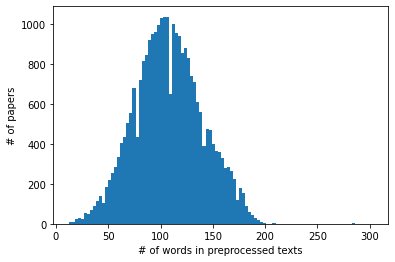

Max # of words: 303
Average # of words: 108.08092317741409


In [0]:
# 텍스트 길이에 대한 그래프
plt.hist([len(t) for t in texts], bins=100)
plt.xlabel('# of words in preprocessed texts')
plt.ylabel('# of papers')
plt.show()
print('Max # of words: {}'.format(max(len(t) for t in texts)))
print('Average # of words: {}'.format(sum(map(len, texts)) / len(texts)))

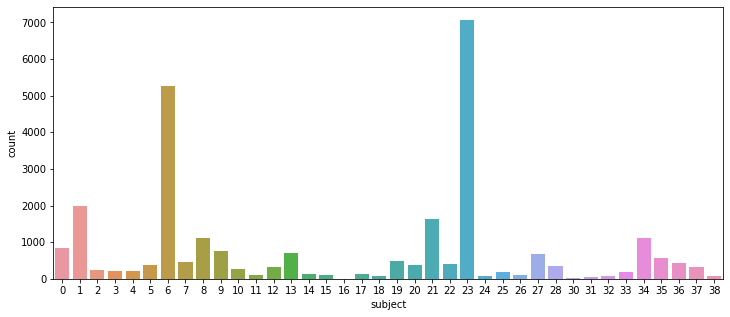

In [0]:
# 클래스 분포에 대한 그래프
fig, ax = plt.subplots()
fig.set_size_inches(w=12, h=5)
ax.set(xlabel="Subject", ylabel = "# of papers")
sns.countplot(labels)

#print(pd.Index(labels).value_counts())

##Doc2Vec

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from sklearn import utils

In [0]:
total_data = [TaggedDocument(words=t, tags=[l]) for t, l in zip(texts, labels)]
utils.shuffle(total_data)
train_data_num = 20700
train_data = total_data[:train_data_num]
test_data = total_data[train_data_num:]

In [0]:
# Doc2Vec을 훈련시키고 가져오거나 로드함
def get_d2v(tag_doc, model_path=None):
    if model_path == None:
        dm = 1
        vector_size = 100
        window = 5
        min_count = 5
        negative = 5
        epochs = 10

        d2v = Doc2Vec(dm=dm, vector_size=vector_size,
                      window=window, min_count=min_count,
                      hs=0, negative=negative, workers=os.cpu_count())
        d2v.build_vocab([d for d in tag_doc])
        d2v.train(tag_doc, total_examples=len(tag_doc), epochs=epochs)
        model_path = 'model/d2v/d{}v{}w{}m{}n{}e{}.d2v'.format(dm, vector_size, window, min_count, negative, epochs)
        d2v.save(os.path.join(cwd, model_path))
        print('Successfully train & save the model...')
        
    else:
        fname = get_tmpfile(os.path.join(cwd, model_path))
        d2v = Doc2Vec.load(fname)
        print('Successfully load the model...')
    
    return d2v, model_path

# Doc2Vec으로 inferred된 결과와 target 쌍을 가져옴
def infer_from_d2v(d2v, tag_doc):
    x, y = zip(*[(d2v.infer_vector(d.words), d.tags[0]) for d in tag_doc])
    return np.asarray(x), np.asarray(y)

In [0]:
d2v, d2v_model_path = get_d2v(train_data)
#d2v_model_path = 'model/d2v/d1v100w5m5n5e10.d2v'
#d2v, d2v_model_path = get_d2v(train_data, d2v_model_path)
x_train, y_train = infer_from_d2v(d2v, train_data)
x_test, y_test = infer_from_d2v(d2v, test_data)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Successfully load the model...
(20700, 100) (20700,) (6857, 100) (6857,)


##ML methods

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score
k_fold = KFold(n_splits=10, shuffle=True)

In [0]:
#clf = LogisticRegression()
#clf = KNeighborsClassifier(n_neighbors=13)
#clf = DecisionTreeClassifier()
#clf = RandomForestClassifier(n_estimators=10)
#clf = GaussianNB()
clf = SVC()

In [0]:
ml_method = 'SVC()'

score = cross_validate(clf, x_train, y_train, cv=k_fold, n_jobs=os.cpu_count(), scoring=['accuracy', 'f1_micro', 'f1_macro'])
result_valid = '=== Cross Validation ===\n' + \
               'Accuracy: {}, F1-micro: {}, F1-macro: {}\n'.format(round(np.mean(score['test_accuracy']), 4),
                                                                   round(np.mean(score['test_f1_micro']), 4),
                                                                   round(np.mean(score['test_f1_macro']), 4))
print(result_valid)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
result_test = '=== For Test Dataset ===\n' + \
              'Accuracy: {}, F1-micro: {}, F1-macro: {}\n'.format(round(accuracy_score(y_test, y_pred), 4),
                                                                  round(f1_score(y_test, y_pred, average='micro'), 4),
                                                                  round(f1_score(y_test, y_pred, average='macro'), 4))
print(result_test)

with open(os.path.join(cwd, 'result.txt'), 'a') as f:
    f.write(d2v_model_path + '\n' + ml_method + '\n')
    f.write(result_valid)
    f.write(result_test)
    f.write('\n')

=== Cross Validation ===
Accuracy: 0.817, F1-micro: 0.817, F1-macro: 0.6865

=== For Test Dataset ===
Accuracy: 0.645, F1-micro: 0.645, F1-macro: 0.424



"\nwith open(os.path.join(cwd, 'result.txt'), 'a') as f:\n    f.write(d2v_model_path + '\n' + ml_method + '\n')\n    f.write(result_valid)\n    f.write(result_test)\n    f.write('\n')\n\nresult_test = ''\n"

##DL methods

In [0]:
# X label 3차원으로 reshape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Y label one-hot으로 변경
y_train = np.eye(40)[y_train]
y_test = np.eye(40)[y_test]

In [0]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, LSTM
from keras import optimizers
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
def stacked_vanilla_rnn():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (100, 1), return_sequences = True))   # return_sequences parameter has to be set True to stack
    model.add(SimpleRNN(50, return_sequences = False))
    model.add(Dense(40))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

def stacked_lstm():
    model = Sequential()
    model.add(LSTM(100, input_shape = (100, 1), return_sequences = True))
    model.add(LSTM(100, return_sequences = False))
    model.add(Dense(40))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(), metrics = [metrics.CategoricalAccuracy()])
    
    return model

In [0]:
rnn_model_path = os.path.join('weight_rnn_testing.hdf5')
checkpoint = ModelCheckpoint(rnn_model_path,
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

model = KerasClassifier(build_fn = stacked_vanilla_rnn,
                        epochs = 3,
                        batch_size = 50,
                        verbose = 1,
                        callbacks=callbacks_list)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_test_ = np.argmax(y_test, axis=1)
result_test = '=== For Test Dataset ===\n' + \
              'Accuracy: {}, F1-micro: {}, F1-macro: {}\n'.format(round(accuracy_score(y_test_, y_pred), 4),
                                                                  round(f1_score(y_test_, y_pred, average='micro'), 4),
                                                                  round(f1_score(y_test_, y_pred, average='macro'), 4))
print(result_test)

In [0]:
model = KerasClassifier(build_fn = stacked_lstm,
                        epochs = 30,
                        batch_size = 50,
                        verbose = 1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_test_ = np.argmax(y_test, axis=1)
result_test = '=== For Test Dataset ===\n' + \
              'Accuracy: {}, F1-micro: {}, F1-macro: {}\n'.format(round(accuracy_score(y_test_, y_pred), 4),
                                                                  round(f1_score(y_test_, y_pred, average='micro'), 4),
                                                                  round(f1_score(y_test_, y_pred, average='macro'), 4))
print(result_test)

##RMDL

In [0]:
!ls

sample_data


In [0]:
!git clone --recursive https://github.com/bsjn16sw/RMDL.git
!pip3 install -r RMDL/requirements.txt
!mv RMDL RMDL_GIT
!cp -r RMDL_GIT/RMDL RMDL

In [0]:
from sklearn.model_selection import train_test_split
x_train_, x_test_, y_train_, y_test_ = train_test_split(texts, labels, test_size=0.272)
x_train_ = [' '.join(x) for x in x_train_]
x_test_ = [' '.join(x) for x in x_test_]

x_train_ = np.asarray(x_train_)
x_test_ = np.asarray(x_test_)
y_train_ = np.asarray(y_train_)
y_test_ = np.asarray(y_test_)

In [0]:
from RMDL import RMDL_Text
batch_size = 500
sparse_categorical = 0
n_epochs = [50, 5, 5]  ## DNN--RNN-CNN
Random_Deep = [3, 0, 0]  ## DNN--RNN-CNN
RMDL_Text.Text_Classification(x_train_, y_train_, x_test_, y_test_,
                              batch_size=batch_size,
                              sparse_categorical=sparse_categorical,
                              random_deep=Random_Deep,
                              epochs=n_epochs)

Using TensorFlow backend.


sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Done1
converted_into_one_hot
tf-idf with 48743 features
39
DNN 0
Train on 20061 samples, validate on 7496 samples
Epoch 1/50
 - 8s - loss: 3.4494 - accuracy: 0.2325 - val_loss: 2.3987 - val_accuracy: 0.2516

Epoch 00001: loss improved from inf to 3.44937, saving model to weights_DNN_0.hdf5
Epoch 2/50
 - 6s - loss: 2.3970 - accuracy: 0.2471 - val_loss: 2.2534 - val_accuracy: 0.3589

Epoch 00002: loss improved from 3.44937 to 2.39696, saving model to weights_DNN_0.hdf5
Epoch 3/50
 - 6s - loss: 2.0680 - accuracy: 0.3831 - val_loss: 2.0863 - val_accuracy: 0.4310

Epoch 00003: loss improved from 2.39696 to 2.06799, saving model to weights_DNN_0.hdf5
Epoch 4/50
 - 6s - loss: 1.7940 - accuracy: 0.4773 - val_loss: 2.1093 - val_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
!ls

RMDL	     weights_CNN_0.hdf5  weights_DNN_0.hdf5
RMDL_GIT     weights_CNN_1.hdf5  weights_DNN_1.hdf5
sample_data  weights_CNN_2.hdf5  weights_DNN_2.hdf5
